In [1]:
# Parkinsonics Other Measures Data Analysis - MoCA
# Kevin Li
# 05.25.2020

import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.multitest as smt
import statsmodels.api as sm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import missingno as msno
import os

# Exploratory Analysis of MoCA All Visits Data

Load MoCA data and ID sheet, clean as necessary

In [4]:
# Load MoCA scores
mcdf=pd.read_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures\MOCA_all_visits_08262016.xlsx')

# Clean up column names: remove "vrqol_" from beginning
newcols=['ID']
for i in mcdf.columns[1:]:
    newcols.append(i[5:])
mcdf.columns=newcols
    
# Load randomization patient ID list
IDdf=pd.read_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Parkinsonics_RandID_ List_DID.xlsx')
IDdf=IDdf[:-5]
S_group=IDdf.loc[IDdf['First Intervention']=='S']
D_group=IDdf.loc[IDdf['First Intervention']=='D']
M_gen=IDdf.loc[IDdf['Gender']=='M']
F_gen=IDdf.loc[IDdf['Gender']=='F']

# Clean datatypes
IDdf['ID']=IDdf['ID'].astype(float)
IDsort=IDdf['ID'].sort_values().reset_index()['ID']

mcdf=pd.merge(mcdf, IDdf, on='ID')

# Drop patient ID 115802 for the 999 data in attn at V2
# cannot verify if this is missing data so will not treat it as such
mcdf=mcdf.drop(22)

Find percentage of missing data

In [5]:
miss_count=0
tot_count=0
for col in range(len(mcdf.columns)-4):
    for row in range(25):
        tot_count+=1
        if np.isnan(mcdf.iloc[row, col]) or mcdf.iloc[row, col]==999:
            miss_count+=1
                
miss_ratio=miss_count/tot_count
miss_ratio

0.00031620553359683795

Separate the subcategory totals of mcdf data, all timepoints in one df

7 subscores (not counting dsu, since atn is sum of dsu comps)

In [6]:
vis=['ID', 'visuo_total_BL', 'visuo_total_V01', 'visuo_total_V02', 'visuo_total_V03', 'visuo_total_V04', 'visuo_total_V05']
nam=['ID', 'naming_total_BL', 'naming_total_V01', 'naming_total_V02', 'naming_total_V03', 'naming_total_V04', 'naming_total_V05']
dsu=[['ID', 'digits_total_BL', 'digits_total_V01', 'digits_total_V02', 'digits_total_V03', 'digits_total_V04', 'digits_total_V05'],
         ['ID', 'sub_total_BL', 'sub_total_V01', 'sub_total_V02', 'sub_total_V03', 'sub_total_V04', 'sub_total_V05']]
atn=['ID', 'attn_total_BL', 'attn_total_V01', 'attn_total_V02', 'attn_total_V03', 'attn_total_V04', 'attn_total_V05']
lan=['ID', 'lang_total_BL', 'lang_total_V01', 'lang_total_V02', 'lang_total_V03', 'lang_total_V04', 'lang_total_V05']
abn=['ID', 'abs_total_BL', 'abs_total_V01', 'abs_total_V02', 'abs_total_V03', 'abs_total_V04', 'abs_total_V05']
rec=['ID', 'delrec_total_BL', 'delrec_total_V01', 'delrec_total_V02', 'delrec_total_V03', 'delrec_total_V04', 'delrec_total_V05']
ori=['ID', 'orient_total_BL', 'orient_total_V01', 'orient_total_V02', 'orient_total_V03', 'orient_total_V04', 'orient_total_V05']
tot=['ID', 'total_BL', 'total_V01', 'total_V02', 'total_V03', 'total_V04', 'total_V05']

subscores=[vis, nam, atn, lan, abn, rec, ori, tot]
names=['Visuospatial', 'Naming', 'Attention', 'Language', 'Abstraction', 'Delayed Recall', 'Orientation', 'Total']

Populate the atn columns with sums of columns from dsu, since atn is the subscore

In [7]:
for i in range(6):
    mcdf[atn[i+1]]=mcdf[dsu[0][i+1]]+mcdf[dsu[1][i+1]]

In [8]:
mcdf=mcdf.reset_index().iloc[:, 1:]

Implement LOCF for missing data points

In [9]:
# Step 1: Check BL for each subscore, drop patients with nan values for that subscore & SI
miss_ID=[0]
miss_sub=['blank']
miss_group=[0]
copydf=mcdf.copy()

for i in range(7):
    score=subscores[i]
    for ID in range(25):
        if np.isnan(copydf.iloc[ID, i+1]):
            if miss_sub[0]=='blank':
            # If the missing items list is unpopulated
                miss_sub[0]=i
                miss_ID[0]=[mcdf['ID'][ID]]
                miss_group[0]=[mcdf['First Intervention'][ID]]
            else:
            # The missing items list has elements
                count1=0
                for m_subs in miss_sub:
                    if m_subs==i:
                        count2=0
                        for m_ID in miss_ID[-1]:
                            if m_ID==mcdf['ID'][ID]:
                                count2+=1
                        if count2==0:
                            miss_ID[-1].append(mcdf['ID'][ID])
                            miss_group[-1].append(mcdf['First Intervention'][ID])
                        count1+=1
                if count1==0:
                    miss_sub.append(i)
                    miss_ID.append([mcdf['ID'][ID]])
                    miss_group.append([mcdf['First Intervention'][ID]])
            for tp in range(1,7):
                copydf.loc[ID, score[tp]]=float('nan')
                copydf.loc[ID, tot[tp]]=float('nan')
                
            
# Step 2: Check V1-V5 for each subscore, carry forward last observation in place of missing data
for i in range(8):
    tempdf=copydf[subscores[i]]
    # Iterate through each entry of each subscore df, search for nan values
    for tp in range(2,7):
        for ID in range(25):
            # If nan or 999, set equal to value at previous tp
            if np.isnan(tempdf.iloc[ID, tp]):
                if miss_sub[0]=='blank':
             # If the missing items list is unpopulated
                     miss_sub[0]=i
                     miss_ID[0]=[mcdf['ID'][ID]]
                     miss_group[0]=[mcdf['First Intervention'][ID]]
                else:
             # The missing items list has elements
                    count1=0
                    for j in range(len(miss_sub)):
                        if miss_sub[j]==i:
                            count2=0
                            for m_ID in miss_ID[j]:
                                if m_ID==mcdf['ID'][ID]:
                                    count2+=1
                            if count2==0:
                                miss_ID[j].append(mcdf['ID'][ID])
                                miss_group[j].append(mcdf['First Intervention'][ID])
                            count1+=1
                    if count1==0:
                        miss_sub.append(i)
                        miss_ID.append([mcdf['ID'][ID]])
                        miss_group.append([mcdf['First Intervention'][ID]])
                tempdf.iloc[ID, tp]=tempdf.iloc[ID, tp-1]
    if i==0:
        locfdf=tempdf
    if i!=0:    
        locfdf=pd.concat([locfdf, tempdf.iloc[:, 1:]], axis=1, sort=False)
        
locfdf=pd.merge(locfdf, IDdf, on='ID')

C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Modify format of non-LOCF data to match the format of LOCF, to replicate analyses

In [10]:
for i in range(8):
    if i==0:
        origdf=mcdf[subscores[i]]
    else:
        origdf=pd.merge(origdf, mcdf[subscores[i]], on='ID')
mcdf=mcdf.reset_index()
origdf=pd.concat([origdf, mcdf[['Age', 'Gender', 'Hoehn & Yahr', 'First Intervention']]], axis=1)

In [11]:
# Stratify by group

# LOCF data:
S_mc_locf=locfdf.loc[locfdf['First Intervention']=='S']
D_mc_locf=locfdf.loc[locfdf['First Intervention']=='D']

# Original data:
S_mc_orig=origdf.loc[origdf['First Intervention']=='S']
D_mc_orig=origdf.loc[origdf['First Intervention']=='D']


# Missing data visualisation

Utilize missingno to create nullity matrix and nullity correlation heatmap between all vars

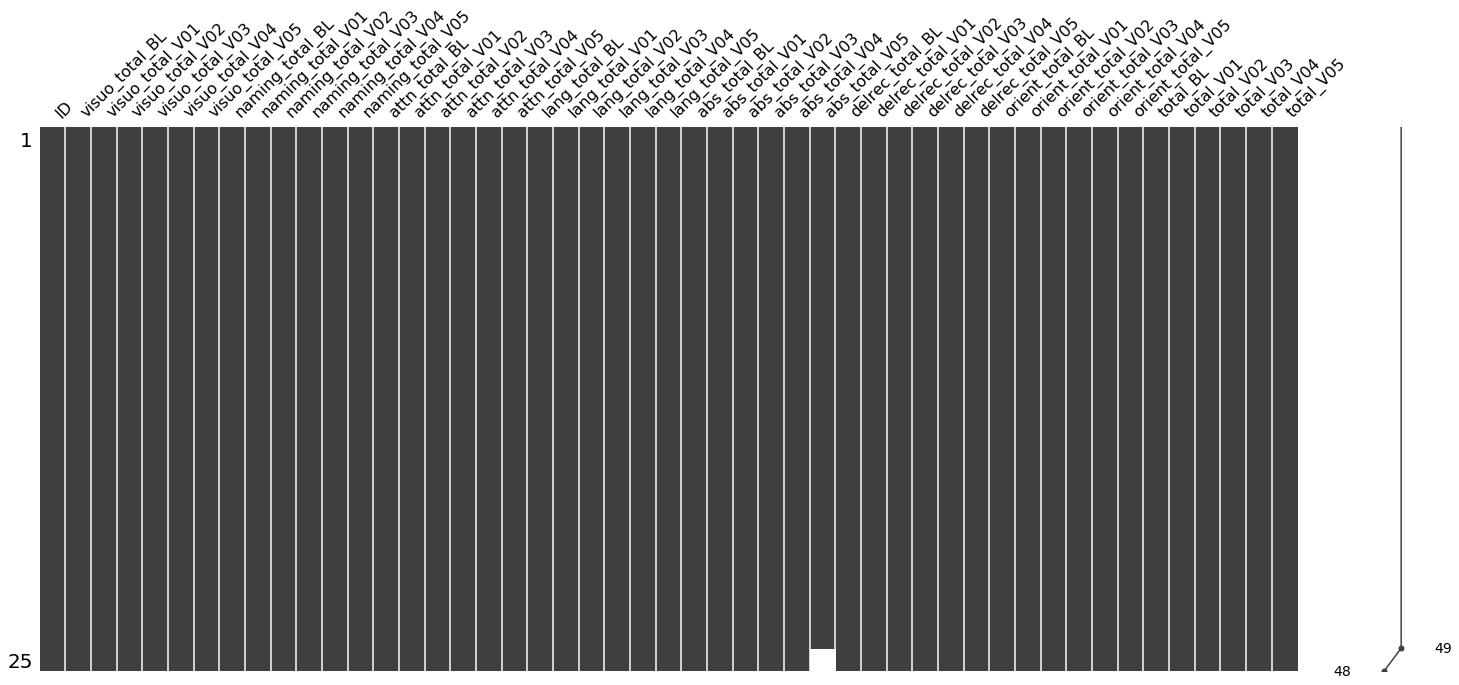

In [16]:
msno.matrix(origdf.loc[:, :'total_V05'])

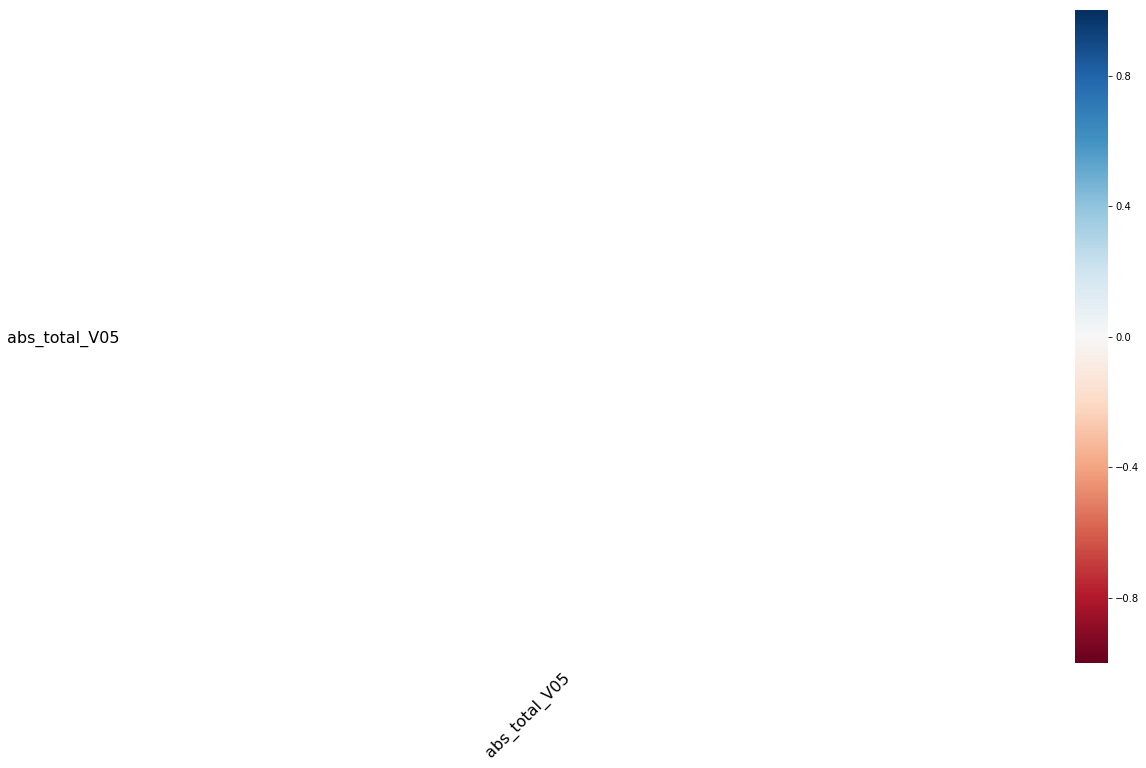

In [12]:
msno.heatmap(origdf)

# Start-end paired T-tests

One p value for each subscore

In [21]:
# Create 4 initial dfs to append to within each loop

# LOCF data:
S_se_locf=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'])
D_se_locf=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'])

count=1
for i in range(8):
    scorename=names[i]
    # Make a list of temp dataframes to iterate thru
    S_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    D_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    tempdflist=[S_temp, D_temp]
    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    S_se=S_mc_locf[subscores[i]].iloc[:, np.r_[1,6]]
    D_se=D_mc_locf[subscores[i]].iloc[:, np.r_[1,6]]
    sedflist=[S_se, D_se]

    for j in range(2):
        tempdf=tempdflist[j]
        tempmc=sedflist[j]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(tempmc.iloc[:, 0], tempmc.iloc[:, 1], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempmc.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempmc.iloc[:, 1])

        if j==0:            
            S_se_locf=pd.concat([S_se_locf, tempdf], sort=False)
        elif j==1:
            D_se_locf=pd.concat([D_se_locf, tempdf], sort=False)
    count+=1
    
# Original data:
S_se_orig=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'])
D_se_orig=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'])

count=1
for i in range(8):
    scorename=names[i]
    # Make a list of temp dataframes to iterate thru
    S_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    D_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    tempdflist=[S_temp, D_temp]
    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    S_se=S_mc_orig[subscores[i]].iloc[:, np.r_[1,6]]
    D_se=D_mc_orig[subscores[i]].iloc[:, np.r_[1,6]]
    sedflist=[S_se, D_se]

    for j in range(2):
        tempdf=tempdflist[j]
        tempmc=sedflist[j]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(tempmc.iloc[:, 0], tempmc.iloc[:, 1], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempmc.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempmc.iloc[:, 1])

        if j==0:            
            S_se_orig=pd.concat([S_se_orig, tempdf], sort=False)
        elif j==1:
            D_se_orig=pd.concat([D_se_orig, tempdf], sort=False)
    count+=1

C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In D orig, p-val<0.05 for Language and Orientation. Correct for multiple comparisons with Simes-Hochberg.

Finding: fail to reject for all pvalues --> report non-corrected p-vals

In [20]:
# Apply Simes-Hoch method to correct FDR: step-up
# Add true/false as a column to see if reject or not
sh_D=smt.multipletests(D_se_locf.iloc[:, 1], alpha=0.05, method='sh')
D_se_locf['pval']=sh_D[1]
cols=['Subscore', 'pval', 'BL Mean', 'V5 Mean']
D_se_locf=D_se_locf.loc[:, cols]
D_se_locf

C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\statsmodels\stats\multitest.py:197: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals <= alphash
C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\statsmodels\stats\multitest.py:256: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


,Subscore,pval,BL Mean,V5 Mean
1,Visuospatial,NaN,4.61538,4.46154
2,Naming,NaN,3,3
3,Attention,NaN,4.92308,4.61538
4,Language,NaN,2,1.69231
5,Abstraction,NaN,2,2
6,Delayed Recall,NaN,4.38462,4.23077
7,Orientation,NaN,5.92308,5.53846
8,Total,NaN,28.7692,27.6154


In [43]:
S_se_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\MOCA\LOCF\MOCA_TTest_StartEnd_S_LOCF.xlsx')
D_se_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\MOCA\LOCF\MOCA_TTest_StartEnd_D_LOCF.xlsx')

S_se_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\MOCA\Original\MOCA_TTest_StartEnd_S_Orig.xlsx')
D_se_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\MOCA\Original\MOCA_TTest_StartEnd_D_Orig.xlsx')

S group - Singing First

LOCF Data Plots


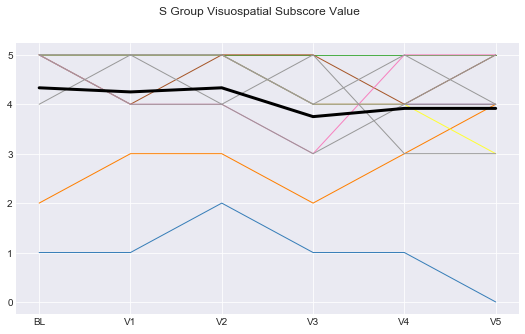

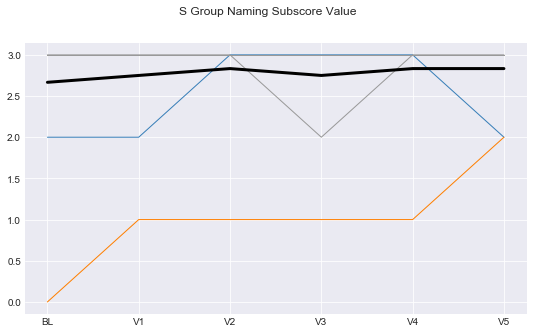

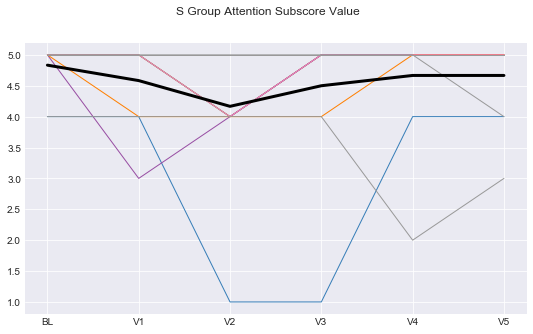

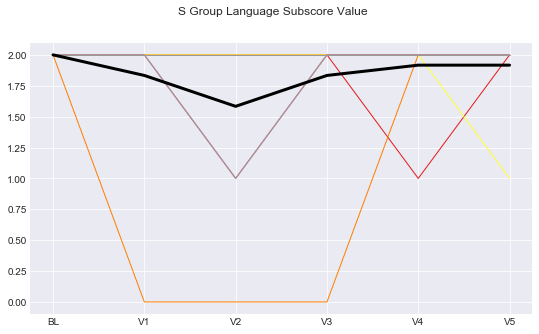

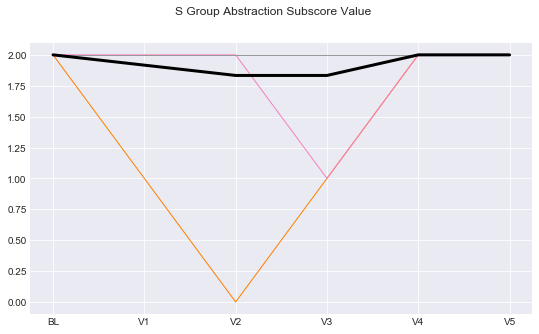

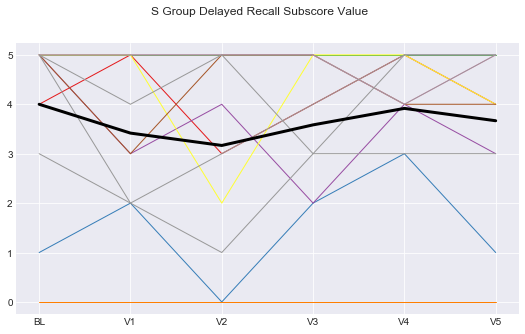

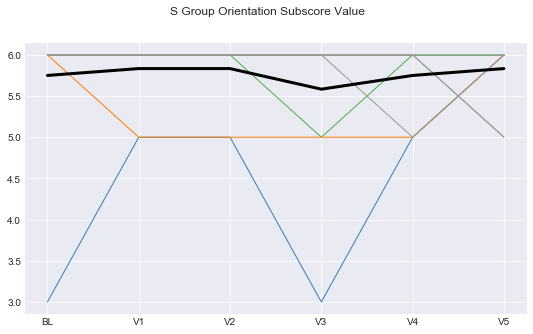

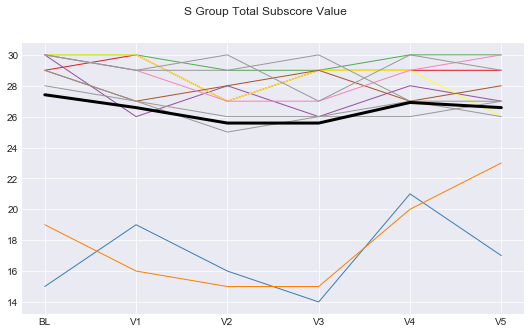

Original Data Plots


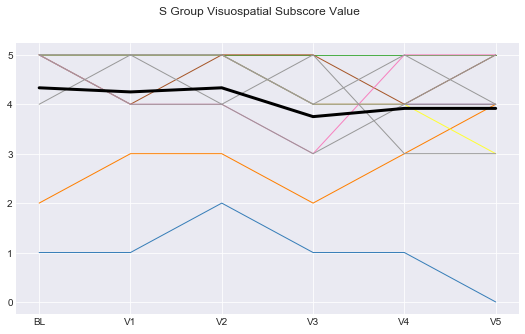

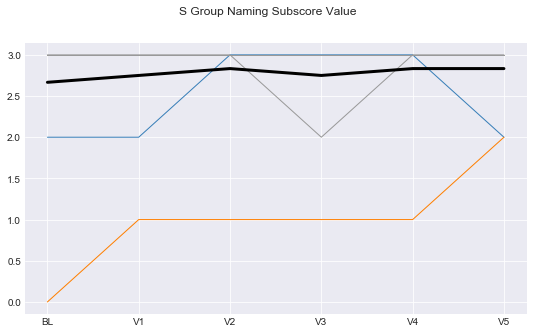

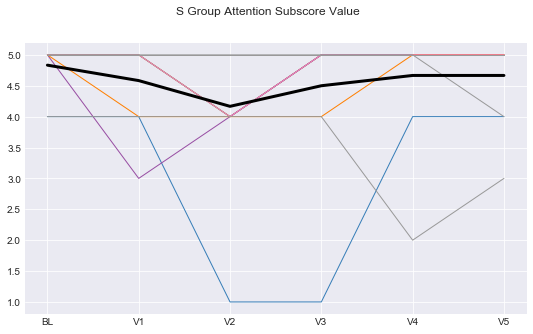

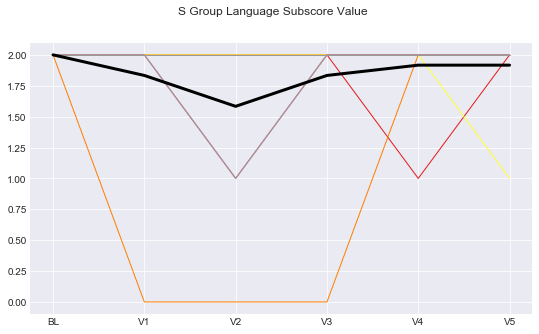

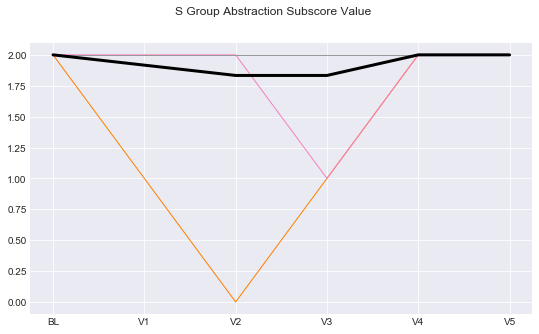

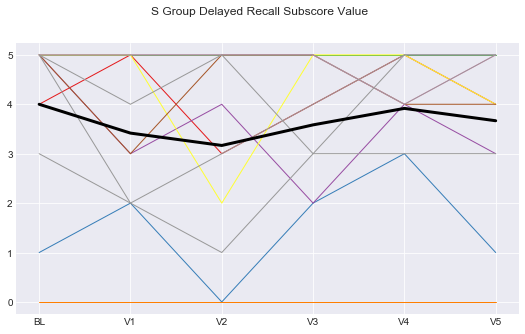

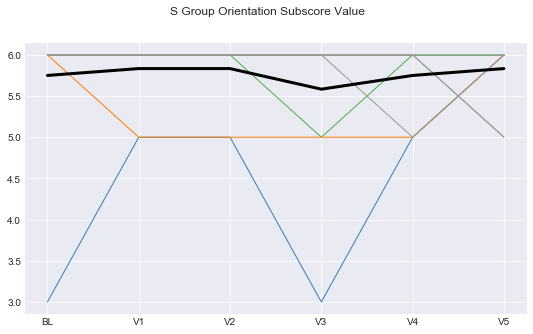

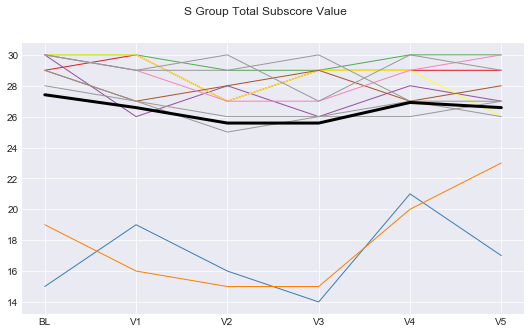

In [47]:
# Need to loop through the different subscores for each S and D
timepoints=['BL', 'V1', 'V2', 'V3', 'V4', 'V5']

# LOCF data
print('LOCF Data Plots')
for i in range(8):
    S_sub=S_mc_locf[subscores[i]]
    # Add a row for the mean of all patients at each tp
    S_sub=S_sub.append(S_sub.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the subscore df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(12):
        S_plot=S_sub.iloc[patient]
        plt.plot(timepoints, S_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, S_sub.iloc[12][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    plt.suptitle('S Group '+names[i]+' Subscore Value')
    plt.show()
    
# Original data
print('Original Data Plots')
for i in range(8):
    S_sub=S_mc_orig[subscores[i]]
    # Add a row for the mean of all patients at each tp
    S_sub=S_sub.append(S_sub.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the subscore df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(12):
        S_plot=S_sub.iloc[patient]
        plt.plot(timepoints, S_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, S_sub.iloc[12][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    plt.suptitle('S Group '+names[i]+' Subscore Value')
    plt.show()

Plot: D Group - Discussion First

LOCF Data Plots


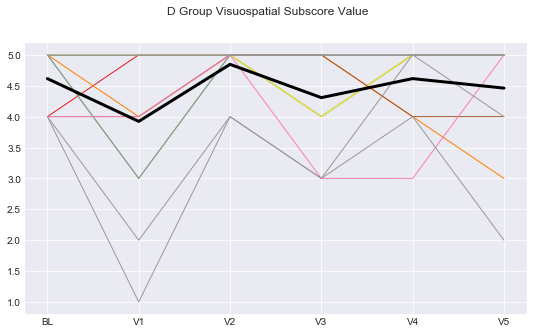

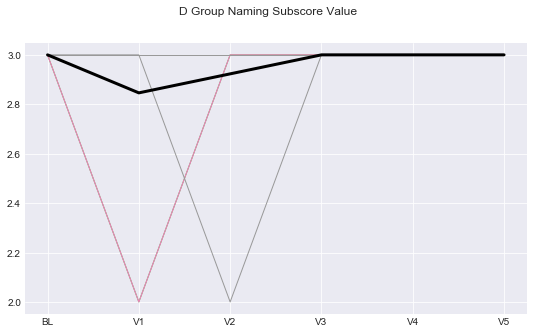

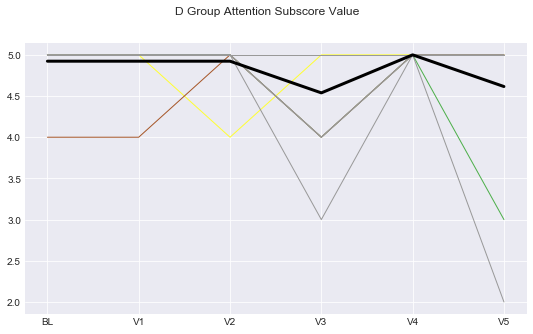

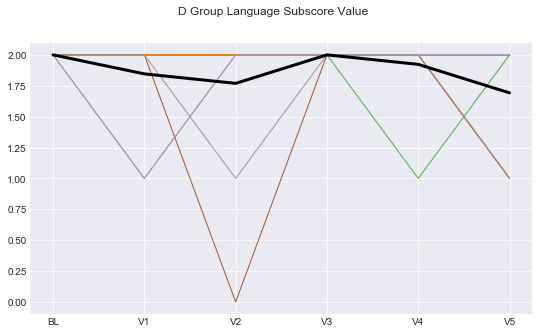

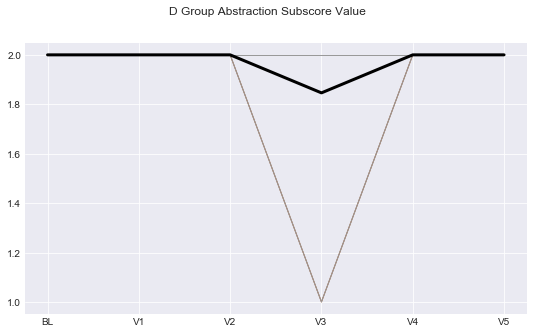

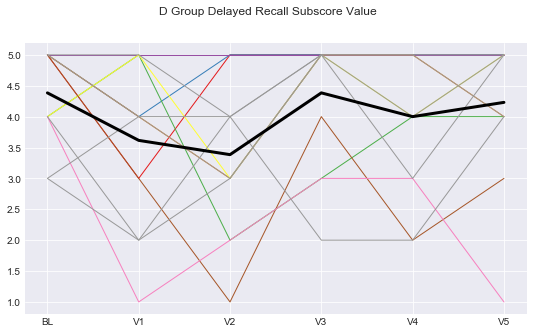

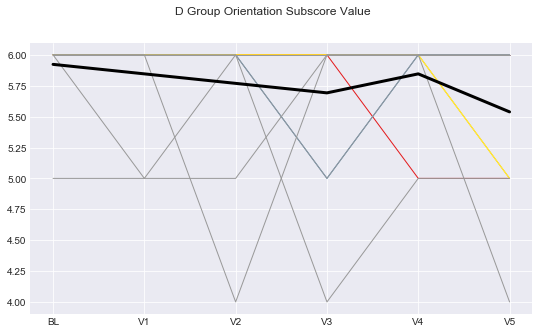

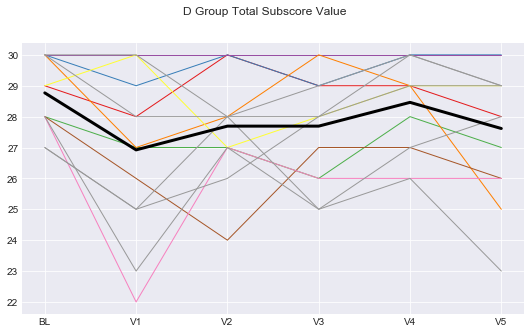

Original Data Plots


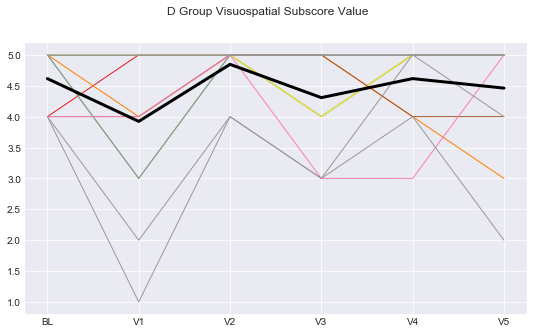

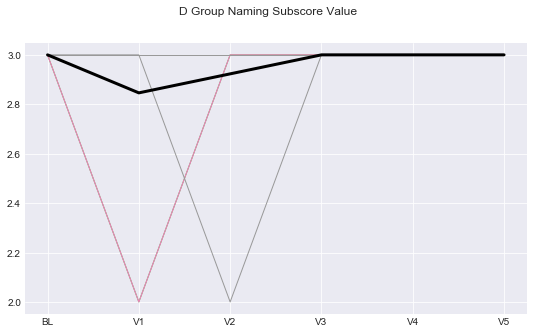

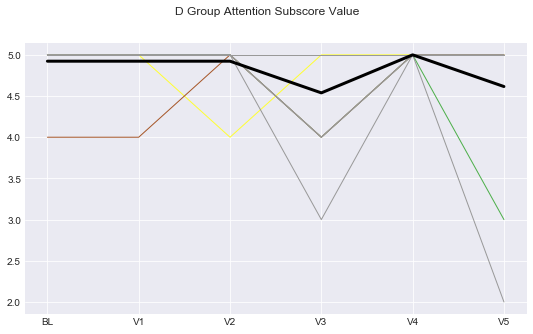

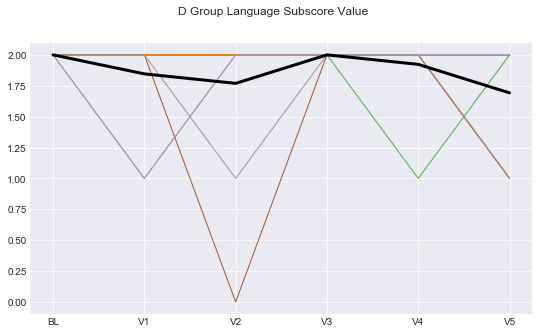

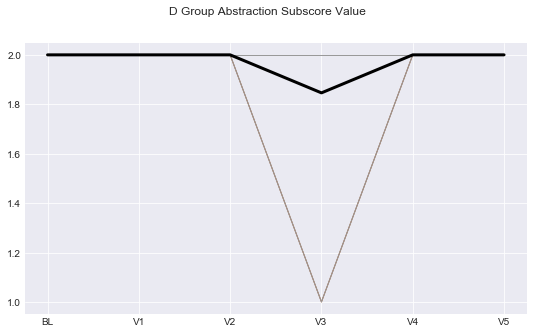

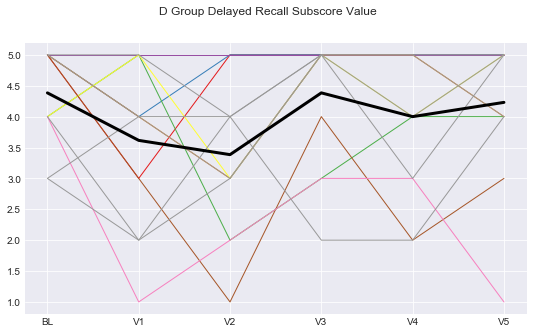

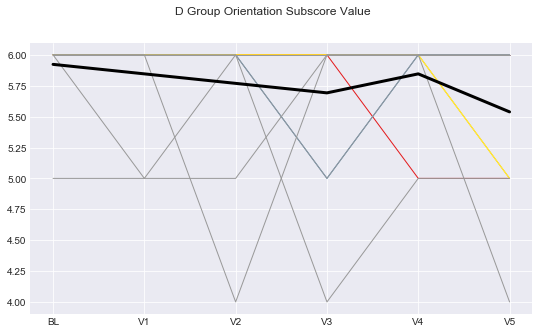

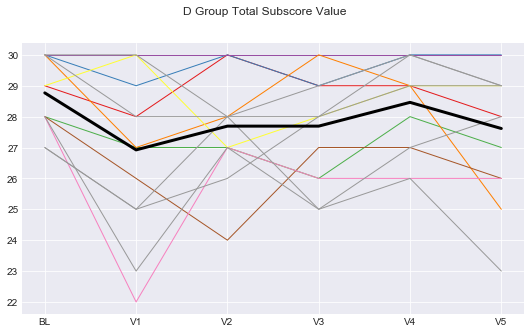

In [50]:
# LOCF data
print('LOCF Data Plots')
for i in range(8):
    D_sub=D_mc_locf[subscores[i]]
    # Add a row fmor the mean of all patients at each tp
    D_sub=D_sub.append(D_sub.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the subscore df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        D_plot=D_sub.iloc[patient]
        plt.plot(timepoints, D_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, D_sub.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    plt.suptitle('D Group '+names[i]+' Subscore Value')
    plt.show()
    
# Original data
print('Original Data Plots')
for i in range(8):
    D_sub=D_mc_orig[subscores[i]]
    # Add a row fmor the mean of all patients at each tp
    D_sub=D_sub.append(D_sub.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the subscore df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        D_plot=D_sub.iloc[patient]
        plt.plot(timepoints, D_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, D_sub.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    plt.suptitle('D Group '+names[i]+' Subscore Value')
    plt.show()



Comparison Data Plots
D Group Plots


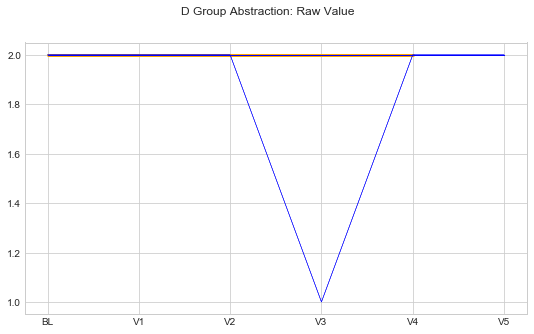

In [53]:
print('Comparison Data Plots')

count=1
for listnum in range(len(miss_sub)):
    subgroup=miss_group[listnum]
    subID=miss_ID[listnum]
    plot_sub=miss_sub[listnum]
    
    miss_S=[]
    miss_D=[]
    for j in range(len(subgroup)):
        if subgroup[j]=='S':
            miss_S.append(subID[j])
        if subgroup[j]=='D':
            miss_D.append(subID[j])
    
    plt.style.use('seaborn-whitegrid')
    palette=plt.get_cmap('Set3')
    
#     print('S Group Plots')
#     full_S=S_group['ID'].astype('int').tolist()
#     for pnum in range(len(miss_S)):
#         miss_S_plot=S_mc_orig[subscores[plot_sub]].loc[S_mc_orig['ID']==miss_S[pnum]].iloc[0]
#         plt.plot(timepoints, miss_S_plot[1:], marker='', color='#FFA500', linewidth=2.5)
#         full_S.remove(miss_S[pnum])
#     for pnum in range(len(full_S)):
#         full_S_plot=S_mc_orig[subscores[plot_sub]].loc[S_mc_orig['ID']==full_S[pnum]].iloc[0]
#         plt.plot(timepoints, full_S_plot[1:], marker='', color='blue', linewidth=0.5)
      
#     fig=plt.gcf()
#     fig.set_size_inches(9,5)
#     plt.suptitle('S Group '+names[plot_sub]+': Raw Value')
#     plt.show()
    
    print('D Group Plots')
    full_D=D_group['ID'].astype('int').tolist()
    for pnum in range(len(miss_D)):
        miss_D_plot=D_mc_orig[subscores[plot_sub]].loc[D_mc_orig['ID']==miss_D[pnum]].iloc[0]
        plt.plot(timepoints, miss_D_plot[1:], marker='', color='#FFA500', linewidth=3)
        full_D.remove(miss_D[pnum])
    for pnum in range(len(full_D)):
        full_D_plot=D_mc_orig[subscores[plot_sub]].loc[D_mc_orig['ID']==full_D[pnum]].iloc[0]
        plt.plot(timepoints, full_D_plot[1:], marker='', color='blue', linewidth=0.5)
      
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    plt.suptitle('D Group '+names[plot_sub]+': Raw Value')
    plt.show()
    

# Groupwise Pre-Post

Does singing better MoCA subscores?

Pre-post intervention: Raw value comparisons 
S: BL vs V2 and D: V2 vs V4

LOCF Data Plots


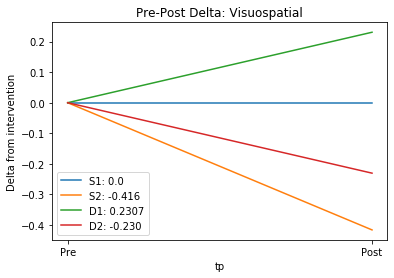

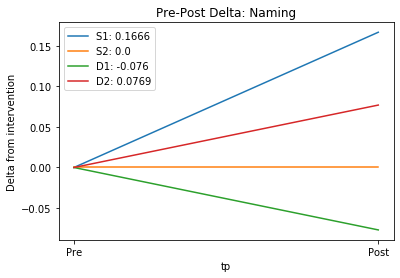

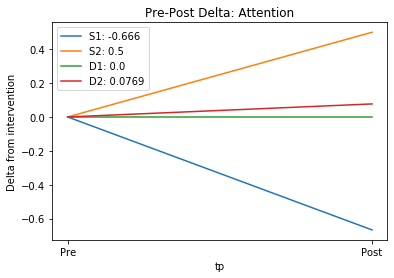

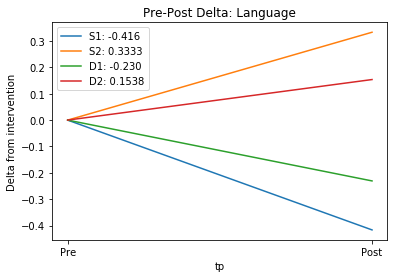

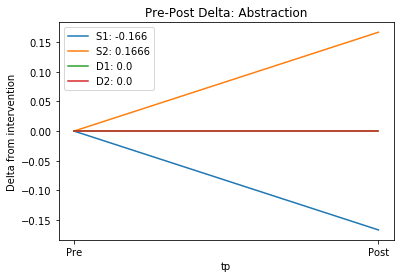

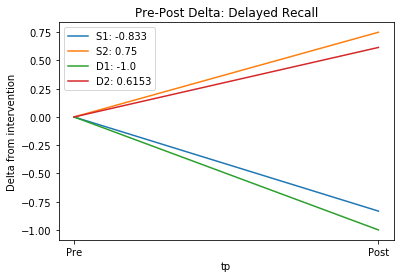

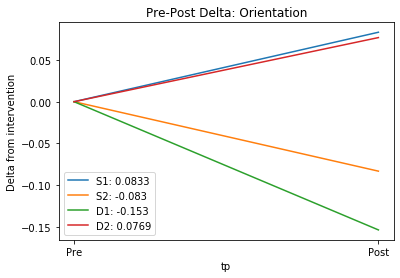

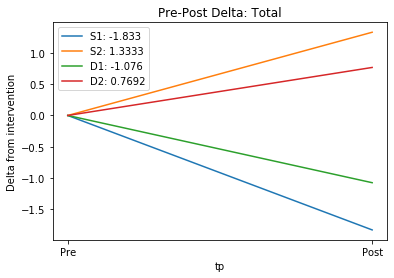

Original Data Plots


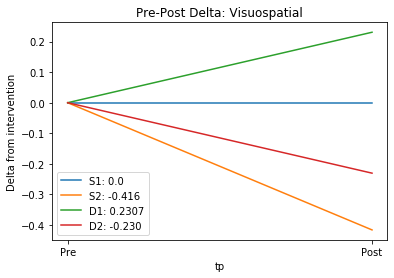

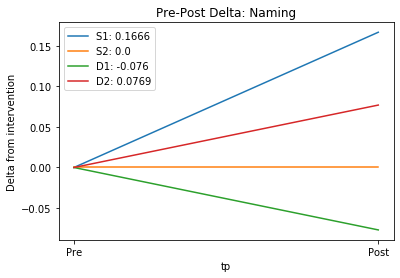

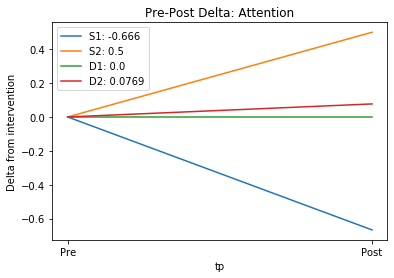

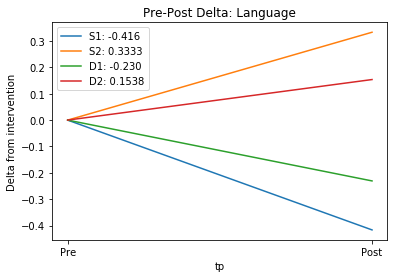

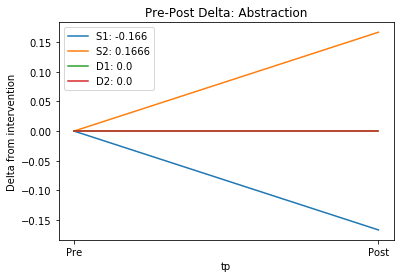

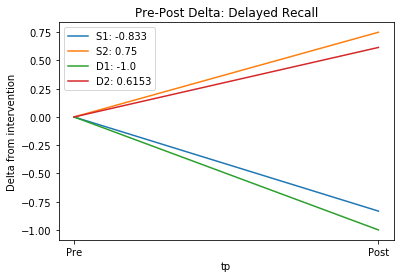

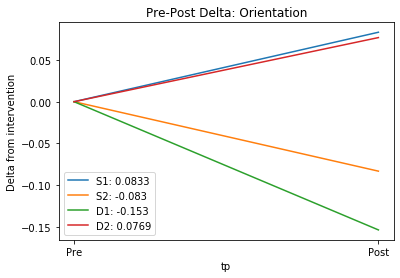

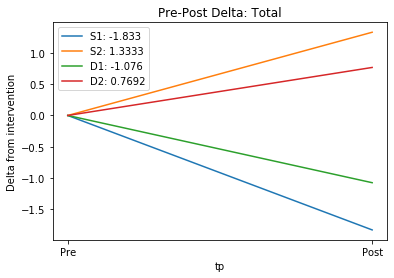

In [38]:
# Plots: want to compare gradients of the 4 groups' DELTAS
# Make lineplots of all 4 groups on one plot for eachof the voice measures

tp=['Post', 'Pre']

# LOCF Data 
print('LOCF Data Plots')
for i in range(8):
    scorename=names[i]
    temp_S=S_mc_locf[subscores[i]].iloc[:, np.r_[1,3,5]]
    temp_D=D_mc_locf[subscores[i]].iloc[:, np.r_[1,3,5]]
    temp_S_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_D_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_S_delta['Delta V2-BL']=temp_S.iloc[:,1]-temp_S.iloc[:,0]
    temp_S_delta['Delta V4-V2']=temp_S.iloc[:,2]-temp_S.iloc[:,1]
    temp_S_delta['Zero']=0
    temp_D_delta['Delta V2-BL']=temp_D.iloc[:,1]-temp_D.iloc[:,0]
    temp_D_delta['Delta V4-V2']=temp_D.iloc[:,2]-temp_D.iloc[:,1]
    temp_D_delta['Zero']=0
    temp_S_avg=temp_S_delta.mean(axis=0)
    temp_D_avg=temp_D_delta.mean(axis=0)
    
    delta_df=pd.DataFrame(columns=['tp'])
    delta_df['tp']=tp
    delta_df.sort_values('tp', ascending=False, inplace=True)
    delta_df['S1']=temp_S_avg[:2].values
    delta_df['S2']=temp_S_avg[2:].values
    delta_df['D1']=temp_D_avg[:2].values
    delta_df['D2']=temp_D_avg[2:].values
    
    plt.figure()
    sns.lineplot(x='tp', y='S1', data=delta_df, sort=False, label='S1: '+str(delta_df['S1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='S2', data=delta_df, sort=False, label='S2: '+str(delta_df['S2'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D1', data=delta_df, sort=False, label='D1: '+str(delta_df['D1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D2', data=delta_df, sort=False, label='D2: '+str(delta_df['D2'].iloc[1])[0:6]).set_title('Pre-Post Delta: '+scorename)
    plt.ylabel('Delta from intervention')
    plt.show()
    
# Original Data 
print('Original Data Plots')
for i in range(8):
    scorename=names[i]
    temp_S=S_mc_orig[subscores[i]].iloc[:, np.r_[1,3,5]]
    temp_D=D_mc_orig[subscores[i]].iloc[:, np.r_[1,3,5]]
    temp_S_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_D_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_S_delta['Delta V2-BL']=temp_S.iloc[:,1]-temp_S.iloc[:,0]
    temp_S_delta['Delta V4-V2']=temp_S.iloc[:,2]-temp_S.iloc[:,1]
    temp_S_delta['Zero']=0
    temp_D_delta['Delta V2-BL']=temp_D.iloc[:,1]-temp_D.iloc[:,0]
    temp_D_delta['Delta V4-V2']=temp_D.iloc[:,2]-temp_D.iloc[:,1]
    temp_D_delta['Zero']=0
    temp_S_avg=temp_S_delta.mean(axis=0)
    temp_D_avg=temp_D_delta.mean(axis=0)
    
    delta_df=pd.DataFrame(columns=['tp'])
    delta_df['tp']=tp
    delta_df.sort_values('tp', ascending=False, inplace=True)
    delta_df['S1']=temp_S_avg[:2].values
    delta_df['S2']=temp_S_avg[2:].values
    delta_df['D1']=temp_D_avg[:2].values
    delta_df['D2']=temp_D_avg[2:].values
    
    plt.figure()
    sns.lineplot(x='tp', y='S1', data=delta_df, sort=False, label='S1: '+str(delta_df['S1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='S2', data=delta_df, sort=False, label='S2: '+str(delta_df['S2'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D1', data=delta_df, sort=False, label='D1: '+str(delta_df['D1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D2', data=delta_df, sort=False, label='D2: '+str(delta_df['D2'].iloc[1])[0:6]).set_title('Pre-Post Delta: '+scorename)
    plt.ylabel('Delta from intervention')
    plt.show()

In [37]:
# Create 4 initial dfs to append to within each loop

# LOCF Data
s1_locf=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'])
s2_locf=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'])
d1_locf=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'])
d2_locf=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'])
sdlist=[s1_locf, s2_locf, d1_locf, d2_locf]

count=1
for i in range(8):
    scorename=names[i]
    # Make a list of temp dataframes to iterate thru
    s1_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    s2_temp=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    d1_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    d2_temp=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    tempdflist=[s1_temp, s2_temp, d1_temp, d2_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_mc=S_mc_locf[subscores[i]].iloc[:, 1:4]
    s2_mc=S_mc_locf[subscores[i]].iloc[:, 4:]
    d1_mc=D_mc_locf[subscores[i]].iloc[:, 1:4]
    d2_mc=D_mc_locf[subscores[i]].iloc[:, 4:]
    mcdflist=[s1_mc, s2_mc, d1_mc, d2_mc]

    for j in range(4):
        tempdf=tempdflist[j]
        tempmc=mcdflist[j]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(tempmc.iloc[:, 0], tempmc.iloc[:, 2], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempmc.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempmc.iloc[:, 2])

        if j==0:
            s1_locf=pd.concat([s1_locf, tempdf], sort=False)
        elif j==1:
            s2_locf=pd.concat([s2_locf, tempdf], sort=False)
        elif j==2:
            d1_locf=pd.concat([d1_locf, tempdf], sort=False)
        elif j==3:
            d2_locf=pd.concat([d2_locf, tempdf], sort=False)
    count+=1
    
# Original Data
s1_orig=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'])
s2_orig=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'])
d1_orig=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'])
d2_orig=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'])
sdlist=[s1_orig, s2_orig, d1_orig, d2_orig]

count=1
for i in range(8):
    scorename=names[i]
    # Make a list of temp dataframes to iterate thru
    s1_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    s2_temp=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    d1_temp=pd.DataFrame(columns=['Subscore', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    d2_temp=pd.DataFrame(columns=['Subscore', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    tempdflist=[s1_temp, s2_temp, d1_temp, d2_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_mc=S_mc_orig[subscores[i]].iloc[:, 1:4]
    s2_mc=S_mc_orig[subscores[i]].iloc[:, 4:]
    d1_mc=D_mc_orig[subscores[i]].iloc[:, 1:4]
    d2_mc=D_mc_orig[subscores[i]].iloc[:, 4:]
    mcdflist=[s1_mc, s2_mc, d1_mc, d2_mc]

    for j in range(4):
        tempdf=tempdflist[j]
        tempmc=mcdflist[j]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(tempmc.iloc[:, 0], tempmc.iloc[:, 2], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempmc.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempmc.iloc[:, 2])

        if j==0:
            s1_orig=pd.concat([s1_orig, tempdf], sort=False)
        elif j==1:
            s2_orig=pd.concat([s2_orig, tempdf], sort=False)
        elif j==2:
            d1_orig=pd.concat([d1_orig, tempdf], sort=False)
        elif j==3:
            d2_orig=pd.concat([d2_orig, tempdf], sort=False)
    count+=1

C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Orig results

s1: Attn, Delrec, Total are sub 0.05. 

d1: Delrec, Total sub 0.05

d2: Lang sub 0.05

Correct for multiple comparisons with Simes-Hochberg

Findings: Post correction for multiple comparisons, only s1 Total p-value remains significant

LOCF results

s1: Attn, DelRec, Tot

d1: Delrec, Total

d2: Lang

Findings: Post correction, s1 Tot only

In [39]:
# Apply Simes-Hoch method to correct FDR: step-up
# Add true/false as a column to see if reject or not
sh_s1_orig=smt.multipletests(s1_orig.iloc[:, 1], alpha=0.05, method='sh')
s1_orig['reject H0']=sh_s1_orig[0]
cols=['Subscore', 'pval', 'reject H0', 'BL Mean', 'V2 Mean']
s1_orig=s1_orig.loc[:, cols]

sh_s2_orig=smt.multipletests(s2_orig.iloc[:, 1], alpha=0.05, method='sh')
s2_orig['reject H0']=sh_s2_orig[0]
cols=['Subscore', 'pval', 'reject H0', 'V2 Mean', 'V4 Mean']
s2_orig=s2_orig.loc[:, cols]

sh_d1_orig=smt.multipletests(d1_orig.iloc[:, 1], alpha=0.05, method='sh')
d1_orig['reject H0']=sh_d1_orig[0]
cols=['Subscore', 'pval', 'reject H0', 'BL Mean', 'V2 Mean']
d1_orig=d1_orig.loc[:, cols]

sh_d2_orig=smt.multipletests(d2_orig.iloc[:, 1], alpha=0.05, method='sh')
d2_orig['reject H0']=sh_d2_orig[0]
cols=['Subscore', 'pval', 'reject H0', 'V2 Mean', 'V4 Mean']
d2_orig=d2_orig.loc[:, cols]

# LOCF Correction
sh_s1=smt.multipletests(s1_locf.iloc[:, 1], alpha=0.05, method='sh')
s1_locf['pval']=sh_s1[1]
cols=['Subscore', 'pval', 'BL Mean', 'V2 Mean']
s1_locf=s1_locf.loc[:, cols]

sh_s2=smt.multipletests(s2_locf.iloc[:, 1], alpha=0.05, method='sh')
s2_locf['pval']=sh_s2[1]
cols=['Subscore', 'pval', 'V2 Mean', 'V4 Mean']
s2_locf=s2_locf.loc[:, cols]

sh_d1=smt.multipletests(d1_locf.iloc[:, 1], alpha=0.05, method='sh')
d1_locf['pval']=sh_d1[1]
cols=['Subscore', 'pval', 'BL Mean', 'V2 Mean']
d1_locf=d1_locf.loc[:, cols]

sh_d2=smt.multipletests(d2_locf.iloc[:, 1], alpha=0.05, method='sh')
d2_locf['pval']=sh_d2[1]
cols=['Subscore', 'pval', 'V2 Mean', 'V4 Mean']
d2_locf=d2_locf.loc[:, cols]

C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\statsmodels\stats\multitest.py:197: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals <= alphash
C:\Users\kevin\Downloads\Install\Programming\Anaconda\lib\site-packages\statsmodels\stats\multitest.py:256: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [40]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
s1_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\MOCA\LOCF\MOCA_TTest_Groupwise_S1_LOCF.xlsx')
s2_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\MOCA\LOCF\MOCA_TTest_Groupwise_S2_LOCF.xlsx')
d1_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\MOCA\LOCF\MOCA_TTest_Groupwise_D1_LOCF.xlsx')
d2_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\MOCA\LOCF\MOCA_TTest_Groupwise_D2_LOCF.xlsx')

s1_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\MOCA\Original\MOCA_TTest_Groupwise_S1_Orig.xlsx')
s2_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\MOCA\Original\MOCA_TTest_Groupwise_S2_Orig.xlsx')
d1_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\MOCA\Original\MOCA_TTest_Groupwise_D1_Orig.xlsx')
d2_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Other Measures Analysis\MOCA\Original\MOCA_TTest_Groupwise_D2_Orig.xlsx')

# Groupwise Delta Significance Testing

Compare deltas of S1 to S2, D1 to D2

In [46]:
# LOCF Data

# Create 4 initial dfs to append to within each loop
s_locf=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'])
d_locf=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'])
dflist=[s_locf, d_locf]

count=1
# test with mobility first
for i in range(8):
    scorename=names[i]
    # Make a list of temp dataframes to iterate thru
    s_locf_temp=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'], index=[str(count)])
    d_locf_temp=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'], index=[str(count)])
    tempdflist=[s_locf_temp, d_locf_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_delta=S_mc_locf[subscores[i]].iloc[:,3]-S_mc_locf[subscores[i]].iloc[:,1]
    s2_delta=S_mc_locf[subscores[i]].iloc[:,5]-S_mc_locf[subscores[i]].iloc[:,3]
    d1_delta=D_mc_locf[subscores[i]].iloc[:,3]-D_mc_locf[subscores[i]].iloc[:,1]
    d2_delta=D_mc_locf[subscores[i]].iloc[:,5]-D_mc_locf[subscores[i]].iloc[:,3]
    deltadflist=[[s1_delta, s2_delta], [d1_delta, d2_delta]]

    for j in range(2):
        tempdf=tempdflist[j]
        delta1=deltadflist[j][0]
        delta2=deltadflist[j][1]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(delta1, delta2, nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(delta1)
        tempdf.iloc[:, 3]=np.mean(delta2)

        if j==0:
            s_locf=pd.concat([s_locf, tempdf], sort=False)
        elif j==1:
            d_locf=pd.concat([d_locf, tempdf], sort=False)
    count+=1
    
# Original Data

# Create 4 initial dfs to append to within each loop
s_orig=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'])
d_orig=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'])
dflist=[s_orig, d_orig]

count=1
# test with mobility first
for i in range(8):
    scorename=names[i]
    # Make a list of temp dataframes to iterate thru
    s_orig_temp=pd.DataFrame(columns=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'], index=[str(count)])
    d_orig_temp=pd.DataFrame(columns=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'], index=[str(count)])
    tempdflist=[s_orig_temp, d_orig_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_delta=S_mc_orig[subscores[i]].iloc[:,3]-S_mc_orig[subscores[i]].iloc[:,1]
    s2_delta=S_mc_orig[subscores[i]].iloc[:,5]-S_mc_orig[subscores[i]].iloc[:,3]
    d1_delta=D_mc_orig[subscores[i]].iloc[:,3]-D_mc_orig[subscores[i]].iloc[:,1]
    d2_delta=D_mc_orig[subscores[i]].iloc[:,5]-D_mc_orig[subscores[i]].iloc[:,3]
    deltadflist=[[s1_delta, s2_delta], [d1_delta, d2_delta]]

    for j in range(2):
        tempdf=tempdflist[j]
        delta1=deltadflist[j][0]
        delta2=deltadflist[j][1]
        tempdf['Subscore']=scorename
        tempdf['pval']=stats.ttest_rel(delta1, delta2, nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(delta1)
        tempdf.iloc[:, 3]=np.mean(delta2)

        if j==0:
            s_orig=pd.concat([s_orig, tempdf], sort=False)
        elif j==1:
            d_orig=pd.concat([d_orig, tempdf], sort=False)
    count+=1

Orig results

S: Delrec and Total both sub 0.05

D: as above

Post SH correction:
Only S Total p value remains significant post-correction

In [48]:
#orig correction
sh_s_orig=smt.multipletests(s_orig.iloc[:, 1], alpha=0.05, method='sh')
s_orig['reject H0']=sh_s_orig[0]
cols=['Subscore', 'pval', 'reject H0', 'S1 Mean Delta', 'S2 Mean Delta']
s_orig=s_orig.loc[:, cols]

sh_d_orig=smt.multipletests(d_orig.iloc[:, 1], alpha=0.05, method='sh')
d_orig['reject H0']=sh_d_orig[0]
cols=['Subscore', 'pval', 'reject H0', 'D1 Mean Delta', 'D2 Mean Delta']
d_orig=d_orig.loc[:, cols]

# LOCF correction
sh_s=smt.multipletests(s_locf.iloc[:, 1], alpha=0.05, method='sh')
s_locf['pval']=sh_s[1]
cols=['Subscore', 'pval', 'S1 Mean Delta', 'S2 Mean Delta']
s_locf=s_locf.loc[:, cols]

sh_d=smt.multipletests(d_locf.iloc[:, 1], alpha=0.05, method='sh')
d_locf['pval']=sh_d[1]
cols=['Subscore', 'pval', 'D1 Mean Delta', 'D2 Mean Delta']
d_locf=d_locf.loc[:, cols]


In [41]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
s_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\MOCA\LOCF\MOCA_TTest_SDelta.xlsx')
d_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\MOCA\LOCF\MOCA_TTest_DDelta.xlsx')
s_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\MOCA\Original\MOCA_TTest_SDelta.xlsx')
d_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\MOCA\Original\MOCA_TTest_DDelta.xlsx')